In [2]:
# NOTE: This is for when the notebook is converted to a python script
# NOTE: Must come before everything else
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))

%reload_ext autoreload
%autoreload 2
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 12})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.rc('figure', figsize=[8, 4])
plt.rc('axes', grid=True)
plt.rcParams.update({'grid.alpha': 0.25})


In [73]:
import kalepy as kale
kale._reload()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import kalepy as kale

from kalepy.plot import nbshow

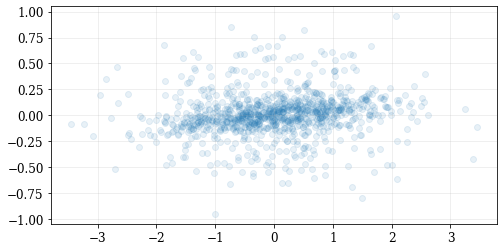

In [5]:
NUM = 1000
NOISE_FRAC = 0.4

sigma = [1.0, 0.1]
corr = [
    [+1.0, +0.5],
    [+0.5, +1.0],
]

cov = np.zeros_like(corr)
for (ii, jj), cc in np.ndenumerate(corr):
    cov[ii, jj] = cc * sigma[ii] * sigma[jj]

data = np.random.multivariate_normal(np.zeros_like(sigma), cov, NUM).T
sub = int(NOISE_FRAC*NUM)
idx = np.random.choice(NUM, sub, replace=False)
temp = np.random.multivariate_normal(
    np.mean(data, axis=-1), np.diag(sigma), size=sub)
data.T[idx, :] = temp

plt.scatter(*data, alpha=0.1)
nbshow()

# Top-Level API

## `kalepy.density`

In [6]:
def check_grid_shapes(pnts, vals, data):

    # Default behavior for N>1 dimensions should be 'grid' densities
    print("Input data has shape: {}, returned pnts: {}, vals: {}".format(
        *[np.shape(xx) for xx in [data, pnts, vals]]))

    # Make sure the shapes of points and values match
    if np.shape(pnts)[0] != 2:
        raise ValueError("`pnts` (shape: {}) should have length 2!".format(np.shape(pnts)))

    shape = np.shape(vals)
    psh = tuple([len(pp) for pp in pnts])
    print("Number of points in each dim: {}".format(psh))
    # Shape of `vals` should match the combined dimensions of `pnts`
    if shape != psh:
        raise ValueError("Shape of density '{}' does not match points '{}'!".format(shape, psh))

    # If the relative-density of the input data are very different, then the length of points in
    #   each dimension should also be different
    frac_var = [kale.utils.iqrange(dd)/np.subtract(*kale.utils.minmax(dd)[::-1]) for dd in data]
    frac_var = np.array(frac_var)
    print("Data iqr/span : ", frac_var)
    '''
    if not np.isclose(*stds, rtol=0.1, atol=0.0) and np.equal(*psh):
        raise ValueError("`pnts` have the same number of elements in each dimension!")
    '''
    if np.sign(np.subtract(*1/frac_var)) != np.sign(np.subtract(*psh)):
        err = "fractional variations of data {} do not match ponts shape {}!".format(frac_var, psh)
        raise ValueError(err)
        
    return


def check_pnts_span(pnts, data):
    # Make sure the `pnts` cover the full range of the data
    for ii, (ee, dd) in enumerate(zip(pnts, data)):
        ex = kale.utils.minmax(ee)
        dx = kale.utils.minmax(dd)
        print("dim {}, edges: [{:.4e}, {:.4e}], data: [{:.4e}, {:.4e}]".format(ii, *ex, *dx))
        if (dx[0] < ex[0]) or (dx[1] > ex[1]):
            raise ValueError("Span of edges ({}) is smaller than data ({})!".format(ex, dx))
            
    return


def check_in_match_out(vin, vout):
    # Output points should match input
    for ii, (pi, po) in enumerate(zip(vin, vout)):
        pi_stats = kale.utils.stats(pi, stats=False)
        po_stats = kale.utils.stats(po, stats=False)
        print("dim {}".format(ii))
        print("\tInput  points: ", pi_stats)
        print("\tOutput points: ", po_stats)

        if not np.all(pi == po):
            err = "Input points: {} do not match output points: {}!".format(pin_stats, pot_stats)
            raise ValueError(err)
            
    return

### No Args

In [7]:
pnts, vals = kale.density(data)

In [8]:
check_grid_shapes(pnts, vals, data)

Input data has shape: (2, 1000), returned pnts: (2,), vals: (68, 130)
Number of points in each dim: (68, 130)
Data iqr/span :  [0.20158986 0.09828371]


In [9]:
check_pnts_span(pnts, data)

dim 0, edges: [-4.6618e+00, 4.6567e+00], data: [-3.4525e+00, 3.4474e+00]
dim 1, edges: [-1.2038e+00, 1.2093e+00], data: [-9.4972e-01, 9.5527e-01]


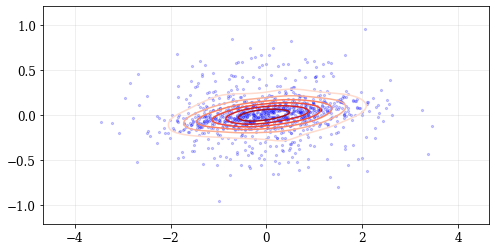

In [10]:
xx, yy = kale.utils.meshgrid(*pnts)
plt.contour(xx, yy, vals, alpha=1.0, cmap='Reds')
plt.scatter(*data, alpha=0.2, s=5, color='b')
nbshow()

### Given `points`

In `grid` mode

In [22]:
_pnts = [np.histogram(dd, bins='auto')[1] for dd in data]
pnts_grid, vals_grid = kale.density(data, points=_pnts, grid=True)

In [23]:
check_in_match_out(_pnts, pnts_grid)

dim 0
	Input  points:  (26,) - [-3.45e+00, -3.18e+00, -2.90e+00 ... 2.90e+00, 3.17e+00, 3.45e+00]
	Output points:  (26,) - [-3.45e+00, -3.18e+00, -2.90e+00 ... 2.90e+00, 3.17e+00, 3.45e+00]
dim 1
	Input  points:  (52,) - [-9.50e-01, -9.12e-01, -8.75e-01 ... 8.81e-01, 9.18e-01, 9.55e-01]
	Output points:  (52,) - [-9.50e-01, -9.12e-01, -8.75e-01 ... 8.81e-01, 9.18e-01, 9.55e-01]


In [13]:
check_grid_shapes(pnts_grid, vals_grid, data)

Input data has shape: (2, 1000), returned pnts: (2,), vals: (26, 52)
Number of points in each dim: (26, 52)
Data iqr/span :  [0.20158986 0.09828371]


In [14]:
check_pnts_span(pnts_grid, data)

dim 0, edges: [-3.4525e+00, 3.4474e+00], data: [-3.4525e+00, 3.4474e+00]
dim 1, edges: [-9.4972e-01, 9.5527e-01], data: [-9.4972e-01, 9.5527e-01]


In `scatter` mode

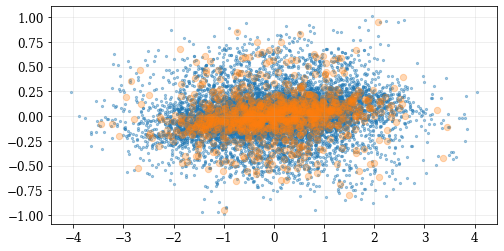

In [59]:
UPSAMPLE = 10
BW_SCALE = 0.5

ndim, ndata = data.shape
num = int(UPSAMPLE*ndata)

_pnts = np.random.choice(ndata, size=num)
_pnts = data.T[_pnts].T

bw = BW_SCALE * np.power(ndata, -1.0/(ndim+4))
bw = np.cov(data) * bw

_pnts += np.random.multivariate_normal([0.0, 0.0], bw, size=num).T

plt.scatter(*_pnts, alpha=0.4, s=5)
plt.scatter(*data, alpha=0.3, s=40)
nbshow()

In [60]:
pnts_scat, vals_scat = kale.density(data, points=_pnts, grid=False)

In [61]:
check_in_match_out(_pnts, pnts_scat)

dim 0
	Input  points:  (10000,) - [-5.46e-01, -1.81e+00, -1.13e+00 ... 3.14e-01, -1.90e+00, 8.98e-01]
	Output points:  (10000,) - [-5.46e-01, -1.81e+00, -1.13e+00 ... 3.14e-01, -1.90e+00, 8.98e-01]
dim 1
	Input  points:  (10000,) - [1.39e-01, -6.22e-02, 2.60e-03 ... 2.17e-01, -7.12e-02, 3.55e-01]
	Output points:  (10000,) - [1.39e-01, -6.22e-02, 2.60e-03 ... 2.17e-01, -7.12e-02, 3.55e-01]


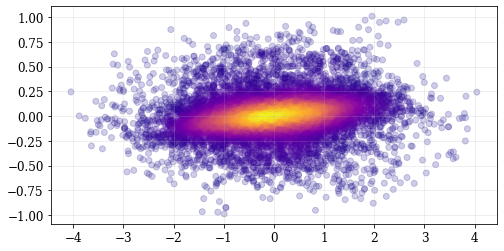

In [62]:
smap = kale.plot._get_smap(vals, cmap='plasma')
colors = smap.to_rgba(vals_scat)
plt.scatter(*pnts_scat, color=colors, alpha=0.2)
nbshow()

In [69]:
def compare_scatter_to_grid(pnts_scat, vals_scat, pnts_grid, vals_grid):
    args = [pnts_scat, vals_scat, pnts_grid, vals_grid]
    # print([kale.utils.jshape(aa) for aa in args])
    
    # Only check points within the range of data values
    extr = [kale.utils.minmax(dd) for dd in data]
    idx = [((extr[dd][0] < pnts_scat[dd]) & (pnts_scat[dd] < extr[dd][-1]))
           for dd in range(2)]
    idx = np.all(idx, axis=0)
    num = np.count_nonzero(idx)
    if num < vals_scat.size//2:
        err = "Very few points found within data values ({}/{})!".format(num, vals_scat.size)
        raise ValueError(err)
    
    pnts_scat = pnts_scat.T[idx].T
    vals_scat = vals_scat.T[idx].T
    
    # find which grid point each scatter point belongs in
    idx = [np.digitize(pp, gg) - 1 for gg, pp in zip(pnts_grid, pnts_scat)]
    vals = vals_grid[idx[0], idx[1]]

    # Compare to grid values
    diff = np.fabs(vals_scat - vals) / np.min([vals_scat, vals], axis=0)
    quants = kale.utils.quantiles(diff, sigmas=[-1, 0, 1])
    print("Difference quantiles between scatter and grid values:", quants)
    # Raise error if differences are too far off
    limits = [0.1, 0.2, 0.5]
    if np.any(quants > limits):
        raise ValueError("Match is unacceptably poor!")
    
    return
    
# print(np.shape(pnts_grid))
compare_scatter_to_grid(pnts_scat, vals_scat, pnts_grid, vals_grid)

Difference quantiles between scatter and grid values: [0.03100138 0.11877342 0.3125169 ]
